## 1. Introduction to RNA-Seq theory and workflow

In [7]:
if (!requireNamespace("BioManager"))
  install.packages("BiocManager")

Loading required namespace: BioManager

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 1.1 RNA-Seq Packages and Workflow
1. DESeq2 package
2. workflow

In [9]:
# install DESeq2
BiocManager::install("DESeq2")

# Check the version of the BSgenome package
packageVersion("DESeq2")

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'DESeq2'

also installing the dependencies ‘bit’, ‘bit64’, ‘plogr’, ‘RSQLite’, ‘xtable’, ‘GenomeInfoDb’, ‘XVector’, ‘DelayedArray’, ‘AnnotationDbi’, ‘annotate’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘RcppArmadillo’


Warning message in install.packages(...):
“installation of package ‘genefilter’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘DESeq2’ had non-zero exit status”
Old packages: 'pbdZMQ', 'broom', 'callr', 'cpp11', 'digest', 'DT', 'labeling',
  'rmarkdown', 'foreign', 'nlme'



In [ ]:
# Load library for DESeq2
library(DESeq2)

# Load library for RColorBrewer
library(RColorBrewer)

# Load library for pheatmap
library(pheatmap)

# Load library for tidyverse
library(tidyverse)

### 1.2 Reading Alignments
1. count of reads aligned to extron
2. Exploring the raw count matrix

In [ ]:
# Explore the first six observations of smoc2_rawcounts
head(smoc2_rawcounts,6)

# Explore the structure of smoc2_rawcounts
str(smoc2_rawcounts)

###1.3 Differential gene expression
1. DGE Theory, negative bionormial model
2. DGE Theory: Metadata
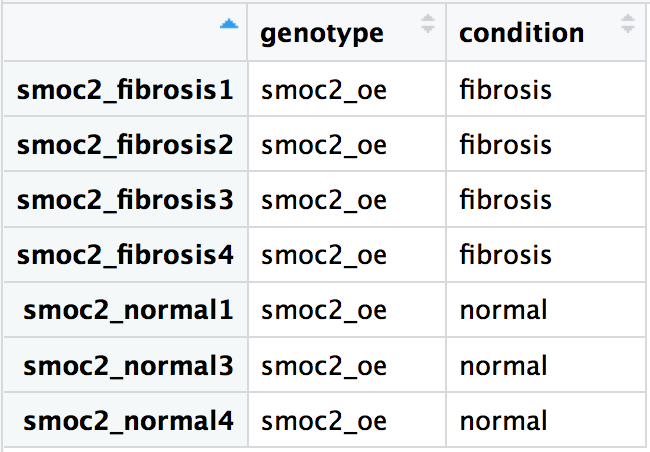

In [ ]:
# Create genotype vector
genotype <- c("smoc2_oe","smoc2_oe","smoc2_oe","smoc2_oe","smoc2_oe","smoc2_oe","smoc2_oe")

# Create condition vector
condition <- c("fibrosis","fibrosis","fibrosis","fibrosis","normal","normal", "normal")

# Create data frame
smoc2_metadata <- data.frame(genotype, condition)

# Assign the row names of the data frame
rownames(smoc2_metadata) <- c("smoc2_fibrosis1","smoc2_fibrosis2", "smoc2_fibrosis3", "smoc2_fibrosis4", "smoc2_normal1","smoc2_normal3", "smoc2_normal4")

## 2. Exploratory data analysis
1. Organize data for DESeq2
2. Count normalization
3. Hierarchical heatmap
4. Principle component analysis


### 2.1 organizing the data
When performing differential expression analyses on your own, the DESeq2 vignette will be the first place to search for answers to any questions. In this exercise, explore the [DESeq2 vignette](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) and use it to pick the best answer below for the question:
1. Why do we use unnormalized counts as inputs
2. Matching metadata and counts data

In [ ]:
library(DESeq2)
library(dplyr)

condition <- c("fibrosis", "fibrosis", "fibrosis", "fibrosis", "normal", "normal", "normal")

# Use the match() function to reorder the columns of the raw counts
reorder_idx <- match(rownames(smoc2_metadata), colnames(smoc2_rawcounts))
#reorder_idx = c(1,7,5,2,3,4,6)

# Reorder the columns of the count data
reordered_smoc2_rawcounts <- smoc2_rawcounts[ , reorder_idx]

# Create a DESeq2 object
dds_smoc2 <- DESeqDataSetFromMatrix(countData = reordered_smoc2_rawcounts,
                              colData = smoc2_metadata,
                              design = ~ condition)

###2.2 Counts Normalization
1. library depth normalization


In [ ]:
# Determine the size factors to use for normalization
dds_smoc2 <- estimateSizeFactors(dds_smoc2)

# Extract the normalized counts
smoc2_normalized_counts <- counts(dds_smoc2, normalized=TRUE)

### 2.3 Unsupervised clustering analyses
1. log transformation
2. Hierachical clustering with correlation heatmaps


In [ ]:
# Transform the normalized counts 
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)

# Extract the matrix of transformed counts
vsd_mat_smoc2 <- assay(vsd_smoc2)

# Compute the correlation values between samples
vsd_cor_smoc2 <- cor(vsd_mat_smoc2) 

# Plot the heatmap
pheatmap(vsd_cor_smoc2, annotation = select(smoc2_metadata, condition))

### 2.4 Principle Compenent analysis

In [ ]:
# Transform the normalized counts 
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)

# Plot the PCA of PC1 and PC2
plotPCA(vsd_smoc2, intgroup="condition")

## 3. Differential expression analysis with DESeq2

###3.1 DESeq2 Model - Object and formula
1. Create DESeq object
2. Design formula (design = ~ sex + treatment)
3. running


In [ ]:
# Create DESeq2 object
dds_smoc2 <- DESeqDataSetFromMatrix(countData = reordered_smoc2_rawcounts,
                 colData = smoc2_metadata,
                 design = ~ condition)

# Run the DESeq2 analysis
dds_smoc2 <- DESeq(dds_smoc2)

### 3.2 DESeq2 model- exploring dispersions



In [ ]:
# Plot dispersions
plotDispEsts(dds_smoc2)

### 3.3 DESeq2 model - contrasts

In [ ]:
# Extract the results of the differential expression analysis
smoc2_res <- results(dds_smoc2, 
                contrast = c("condition", "fibrosis", "normal"), 
                alpha = 0.05)

#### 3.4 DESeq2 results -LFC shrinkage


In [ ]:
# Shrink the log2 fold change estimates to be more accurate
smoc2_res <- lfcShrink(dds_smoc2, 
                    contrast =  c("condition", "fibrosis", "normal"),
                    res = smoc2_res)
plotMA(smoc2_res, ylim = c(-8, 8))

###3.5 DESeq2 results exploration
1. re-run the results with lfcTrheshold from LFC shrikage
2. Shrink the log2 fold changes
3. summarizing DESeq2 result : output the numbers/percentages of up and down-regulated genes,indenpendent filtering and outliers removed
4. DESeq2 significant results

In [ ]:
# Explore the results() function
?results

# Extract results
smoc2_res <- results(dds_smoc2, 
                contrast = c("condition", "fibrosis", "normal"), 
                alpha = 0.05, 
                lfcThreshold = 0.32)

# Shrink the log2 fold changes
smoc2_res <- lfcShrink(dds_smoc2, 
                    contrast = c("condition", "fibrosis", "normal"), 
                    res = smoc2_res)

# summary of DESeq2 result
summary(smoc2_res)

In [ ]:
# Save results as a data frame
smoc2_res_all <- data.frame(smoc2_res)

# Subset the results to only return the significant genes with p-adjusted values less than 0.05
smoc2_res_sig <- subset(smoc2_res_all, padj < 0.05)

## 4. Exploration of differential expression results


### 4.1 Visualization of results
1. MA and volcano plots
2. Heatmap

In [ ]:
# Create MA plot
plotMA(smoc2_res)

# Generate logical column 
smoc2_res_all <- data.frame(smoc2_res) %>% mutate(threshold = padj < 0.05)
              
# Create the volcano plot
ggplot(smoc2_res_all) + 
        geom_point(aes(x = log2FoldChange, y = -log10(padj), color = threshold)) + 
        xlab("log2 fold change") + 
        ylab("-log10 adjusted p-value") + 
        theme(legend.position = "none", 
              plot.title = element_text(size = rel(1.5), hjust = 0.5), 
              axis.title = element_text(size = rel(1.25)))

In [ ]:
# Subset normalized counts to significant genes
sig_norm_counts_smoc2 <- normalized_counts_smoc2[rownames(smoc2_res_sig), ]

# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")
 
# Plot heatmap
pheatmap(sig_norm_counts_smoc2, 
         color = heat_colors, 
         cluster_rows = TRUE, 
         show_rownames = FALSE,
         annotation = select(smoc2_metadata, condition), 
         scale = "row")

### 4.2 RNA-Seq DE analysis summary
1. setup
2. experimental planning
3. Workflow summary
4. Analysis summary
5. DE analysis
6. DE analysis results
all_metadata as shown below:
![image.png](# )

In [ ]:
# RNA-Seq DE workflow

# Check that all of the samples are in the same order in the metadata and count data
all(rownames(all_metadata) %in% colnames(all_rawcounts))

# DESeq object to test for the effect of fibrosis regardless of genotype
dds_all <- DESeqDataSetFromMatrix(countData = all_rawcounts,
                        colData = all_metadata,
                        design = ~ genotype + condition)

# DESeq object to test for the effect of genotype on the effect of fibrosis                        
dds_complex <- DESeqDataSetFromMatrix(countData = all_rawcounts,
                                colData = all_metadata,
                                design = ~ genotype + condition + genotype:condition)

In [ ]:
##  DE analysis
# Log transform counts for QC
vsd_all <- vst(dds_all, blind = TRUE)

# Create heatmap of sample correlation values
vsd_all %>% 
        assay() %>%
        cor() %>%
        pheatmap(annotation =  select(all_metadata, c("condition", "genotype")))
        
# Create the PCA plot for PC1 and PC2 and color by condition 
plotPCA(vsd_all, intgroup = "condition")

# Create the PCA plot for PC1 and PC2 and color by genotype    
plotPCA(vsd_all, intgroup = "genotype")

In [ ]:
## DE analysis result

# Select significant genese with padj < 0.05
smoc2_sig <- subset(res_all, padj < 0.05) %>%
  				data.frame() %>%
  				rownames_to_column(var = "geneID")

# Extract the top 6 genes with padj values
smoc2_sig %>%
	arrange(padj) %>%
	select(geneID, padj) %>%
	head()

###4.3 RNA-Seq next steps

 * Vignee:hp://bioconductor.org/packages/devel/bioc/vignees/DESeq2/inst/doc/DESeq2.html
 
 * Bioconductorsupportsite:hps://support.bioconductor.org(tag'DESeq2')

2. Significant genes interpretation
3. Conclusion